In [1]:
import pandas as pd

# Load datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Add labels
fake_df['label'] = 0  # 0 = Fake
true_df['label'] = 1  # 1 = True

# Combine and shuffle
data = pd.concat([fake_df, true_df], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)


In [2]:
data.head()

,title,text,subject,date,label
0,UnitedHealth's Obamacare exit adds pricing pre...,NEW YORK (Reuters) - UnitedHealth Group Inc’s ...,politicsNews,"April 19, 2016",1
1,Sean Spicer Claims Hitler Never Gassed People...,Sean Spicer s time as press secretary has been...,News,"April 11, 2017",0
2,Irma heads west-northwest as it passes over Ca...,(Reuters) - The eye of Hurricane Irma was pass...,worldnews,"September 6, 2017",1
3,Turkey's defense industry says planning 22 pro...,ANKARA (Reuters) - Turkey is planning 22 new d...,worldnews,"November 2, 2017",1
4,Inauguration Protesters Could Face Decades In...,As liberals are fighting over a picture posted...,News,"June 3, 2017",0


In [3]:
data.shape

(44898, 5)

In [4]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

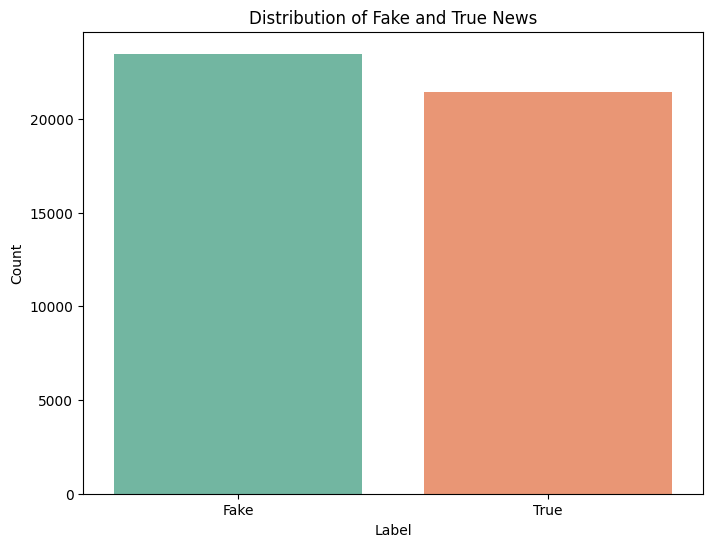

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of fake vs. true news
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Distribution of Fake and True News')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'True'])
plt.show()


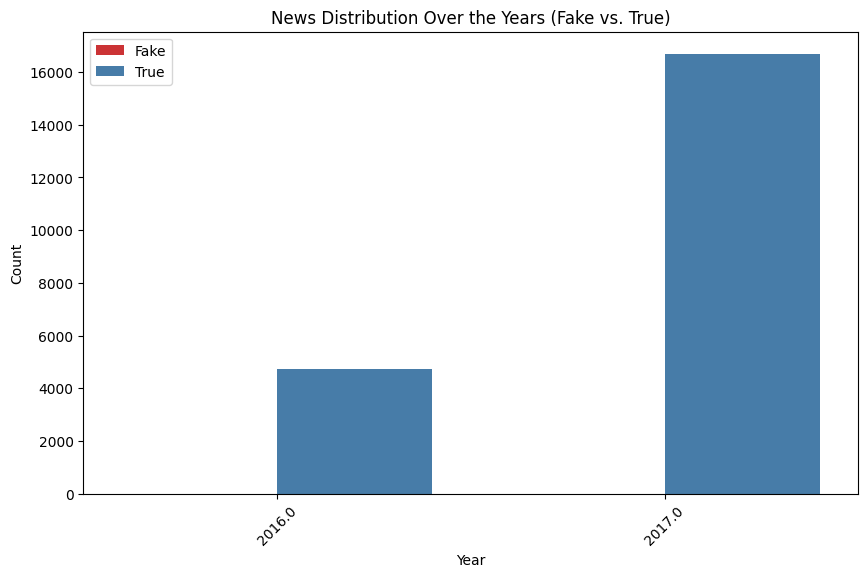

In [6]:
# Convert 'date' column to datetime
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data['year'] = data['date'].dt.year

    # Plot news distribution over years
    plt.figure(figsize=(10, 6))
    sns.countplot(x='year', hue='label', data=data, palette='Set1')
    plt.title('News Distribution Over the Years (Fake vs. True)')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Fake', 'True'])
    plt.show()
else:
    print("No date column found in the dataset.")


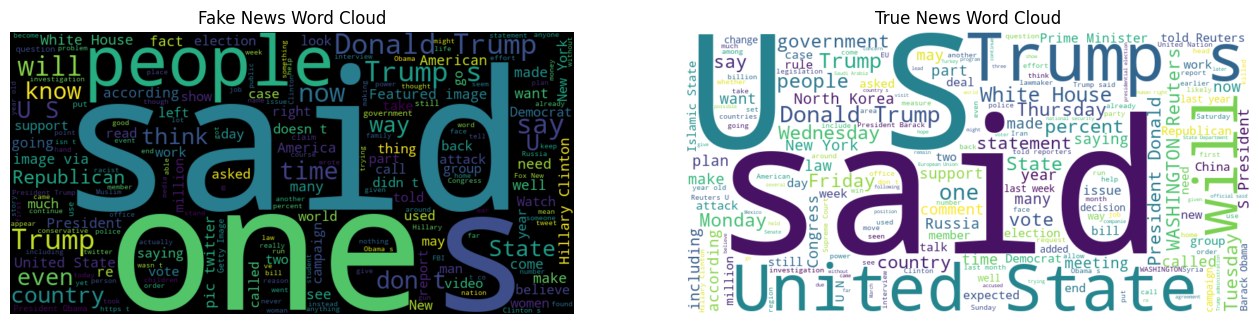

In [7]:
from wordcloud import WordCloud

# Fake news word cloud
fake_text = " ".join(data[data['label'] == 0]['text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)

# True news word cloud
true_text = " ".join(data[data['label'] == 1]['text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)

# Plot side by side
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('True News Word Cloud')
plt.show()


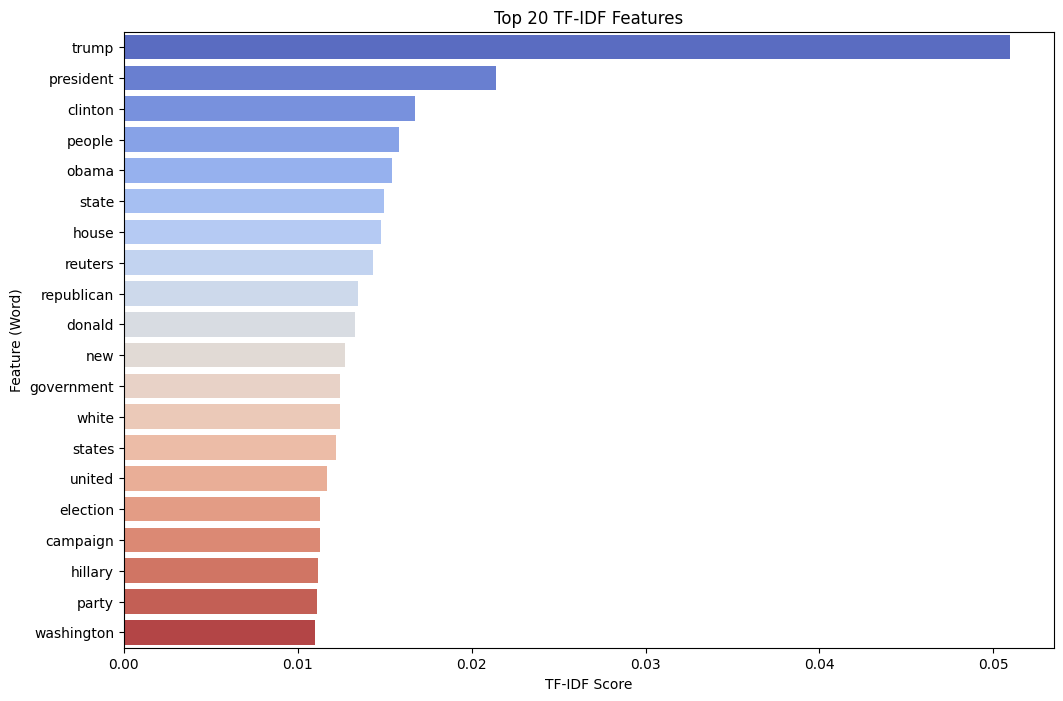

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_vec = vectorizer.fit_transform(data['text'])

# Get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

# Get the average tf-idf score for each word across all samples
avg_tfidf_scores = np.array(X_vec.mean(axis=0)).flatten()

# Combine feature names with their tf-idf scores and sort them by score
sorted_indices = avg_tfidf_scores.argsort()[::-1]
top_n = 20  # You can adjust this value to show more/less words
top_features = feature_names[sorted_indices][:top_n]
top_scores = avg_tfidf_scores[sorted_indices][:top_n]

# Plot the top words
plt.figure(figsize=(12, 8))
sns.barplot(x=top_scores, y=top_features, palette='coolwarm')
plt.title('Top 20 TF-IDF Features')
plt.xlabel('TF-IDF Score')
plt.ylabel('Feature (Word)')
plt.show()


C:\Users\vidit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\vidit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


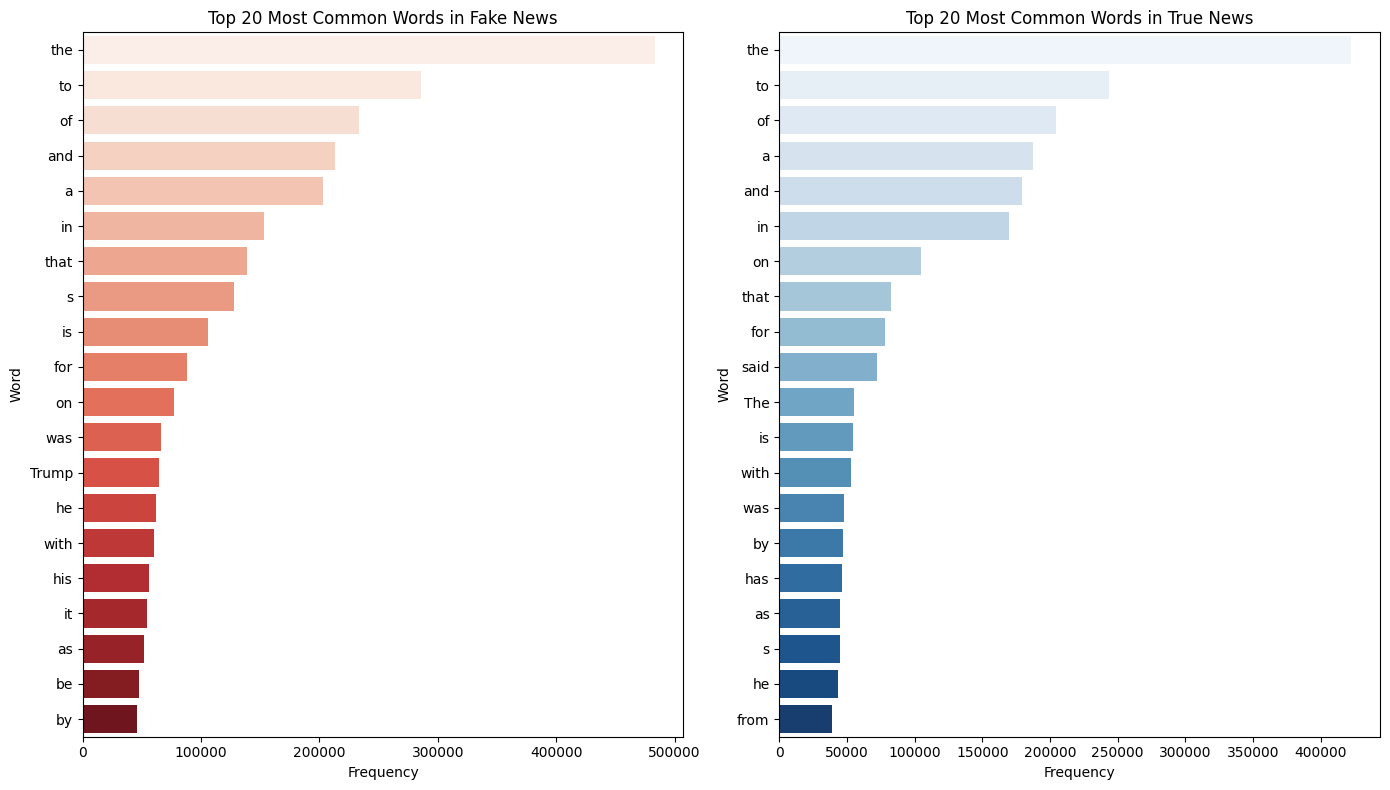

In [9]:
from collections import Counter

# Tokenize and count word frequencies for fake and true news
fake_words = " ".join(data[data['label'] == 0]['text']).split()
true_words = " ".join(data[data['label'] == 1]['text']).split()

fake_word_freq = Counter(fake_words)
true_word_freq = Counter(true_words)

# Get the top 20 most common words
fake_common = fake_word_freq.most_common(20)
true_common = true_word_freq.most_common(20)

# Plot the frequency distributions
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.barplot(x=[word[1] for word in fake_common], y=[word[0] for word in fake_common], palette='Reds')
plt.title('Top 20 Most Common Words in Fake News')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.subplot(1, 2, 2)
sns.barplot(x=[word[1] for word in true_common], y=[word[0] for word in true_common], palette='Blues')
plt.title('Top 20 Most Common Words in True News')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()
plt.show()


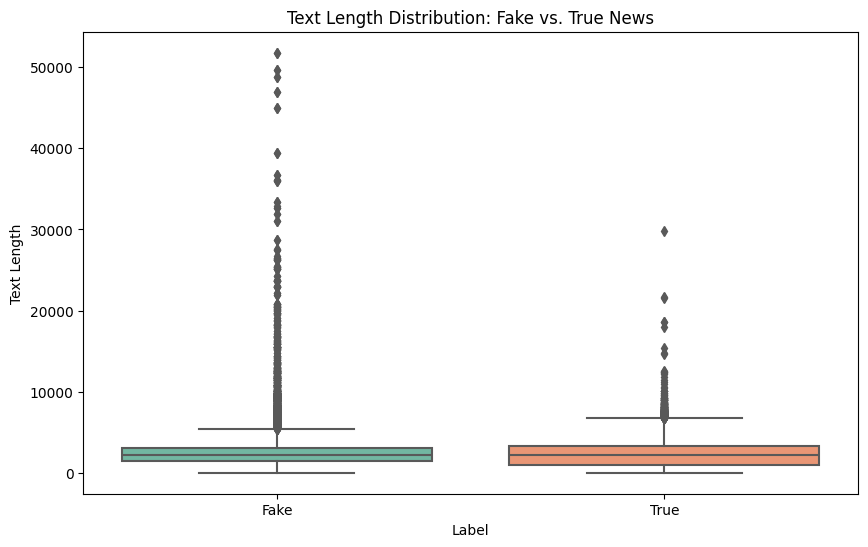

In [10]:
# Add text length to data
data['text_length'] = data['text'].apply(len)

# Plot text length distribution by label (fake vs. true)
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=data, palette='Set2')
plt.title('Text Length Distribution: Fake vs. True News')
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.xticks([0, 1], ['Fake', 'True'])
plt.show()


In [11]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Basic cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

data['text'] = data['text'].apply(clean_text)

# Split data
X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Evaluate
y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.983630289532294
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4679
           1       0.98      0.98      0.98      4301

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



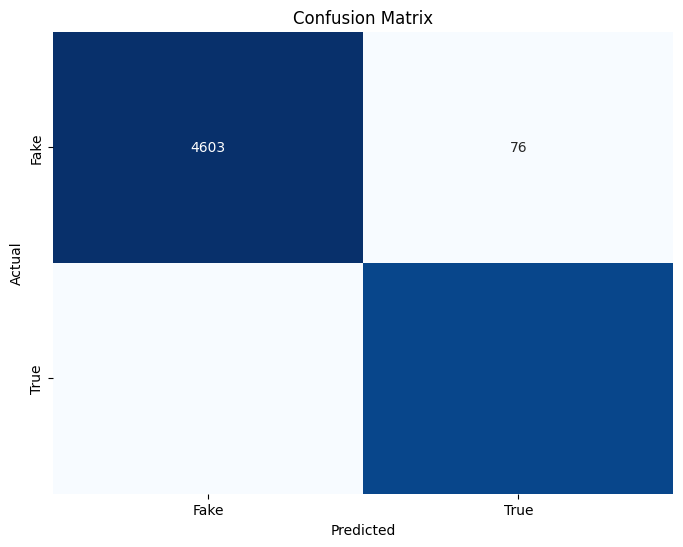

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_test and y_pred are available from the model evaluation
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
import joblib
joblib.dump(model, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')


['vectorizer.pkl']